In [2]:
import ee
ee.Authenticate()   # se abre un link en tu navegador para loguearte con tu cuenta de Google
ee.Initialize()



Successfully saved authorization token.


Carpeta de trabajo: D:\sentinel_data
EE inicializado (credenciales existentes).

=== Bosque (MapBiomas clase 3) 2000–2022 ===
   establecimiento   año   ha_bosque
0           427270  2000  620.055805
1           427270  2001  617.780492
2           427270  2002  618.165929
3           427270  2003  618.734041
4           427270  2004  612.003339
5           427270  2005  611.789109
6           427270  2006  611.111832
7           427270  2007  617.378209
8           427270  2008  617.134723
9           427270  2009  610.200012
10          427270  2010  605.644836
11          427270  2011  603.685549

=== Pérdida de cobertura arbórea (Hansen) 2001–2023 ===
   establecimiento   año  ha_perdida
0           427270  2001    0.000000
1           427270  2002    0.000000
2           427270  2003    0.081160
3           427270  2004    0.243478
4           427270  2005    0.324646
5           427270  2006    0.000000
6           427270  2007    0.324643
7           427270  2008    0.162296
8  

C:\Users\Win10\AppData\Local\Temp\ipykernel_9664\3786246768.py:161: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from current font.
  plt.xlabel("Año"); plt.ylabel("Hectáreas"); plt.grid(True); plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


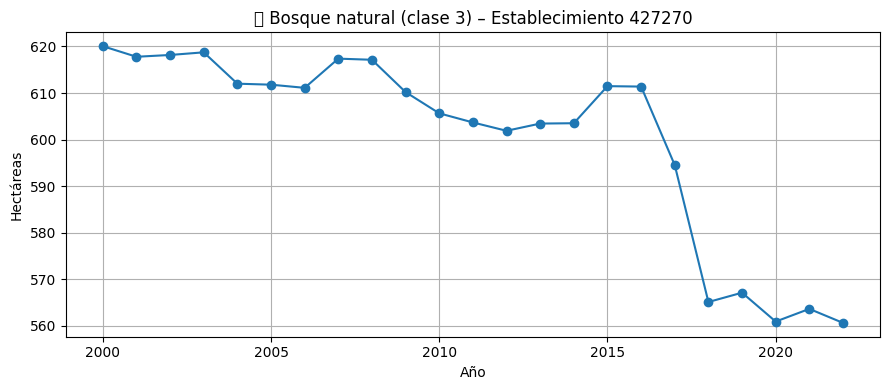

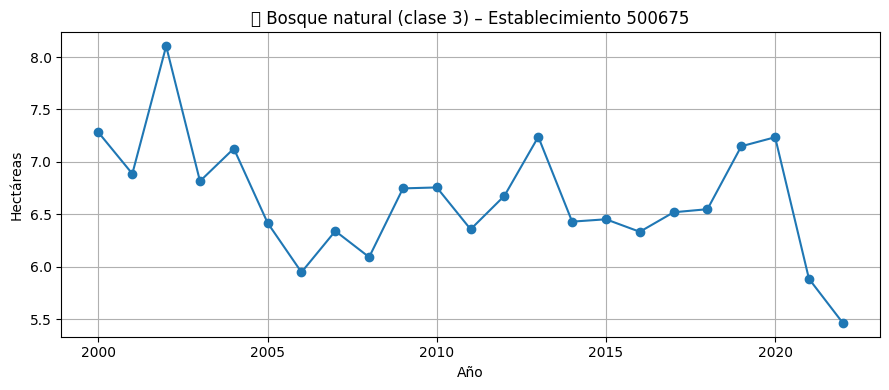

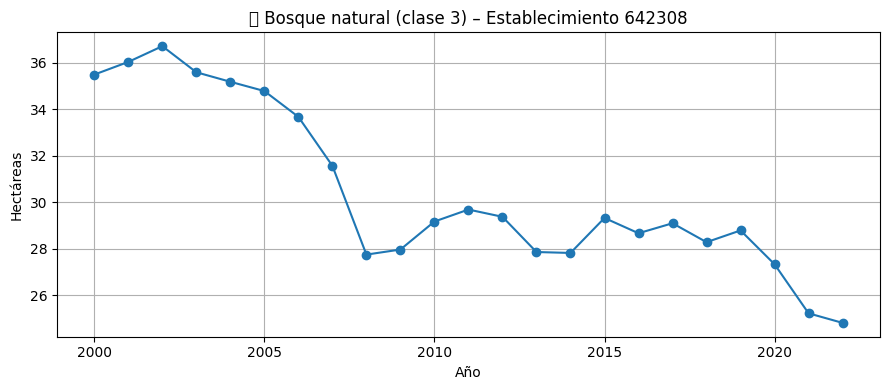

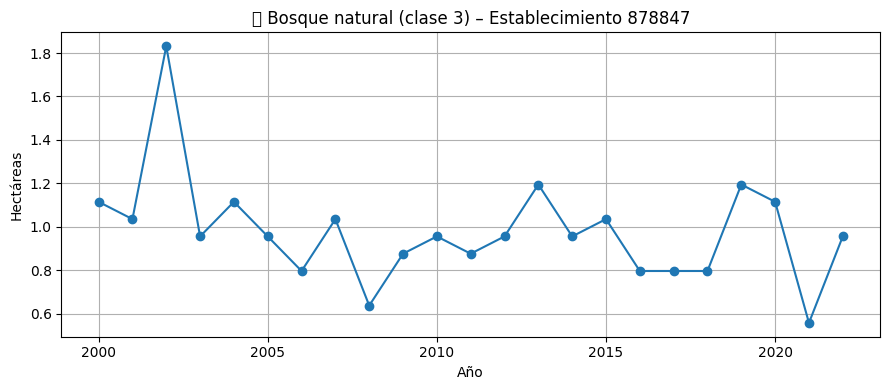

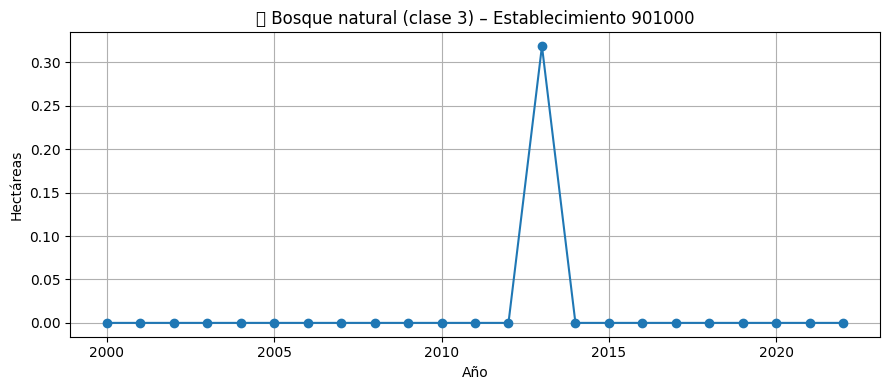

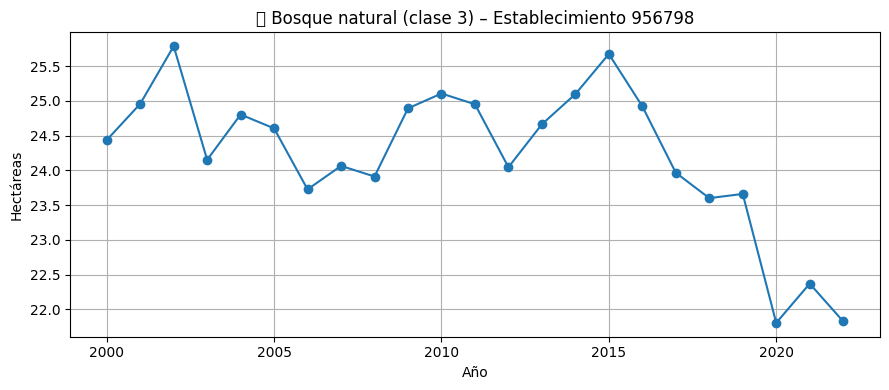

C:\Users\Win10\AppData\Local\Temp\ipykernel_9664\3786246768.py:171: UserWarning: Glyph 129717 (\N{WOOD}) missing from current font.
  plt.xlabel("Año"); plt.ylabel("Hectáreas perdidas"); plt.grid(True); plt.tight_layout()
C:\Users\Win10\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129717 (\N{WOOD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


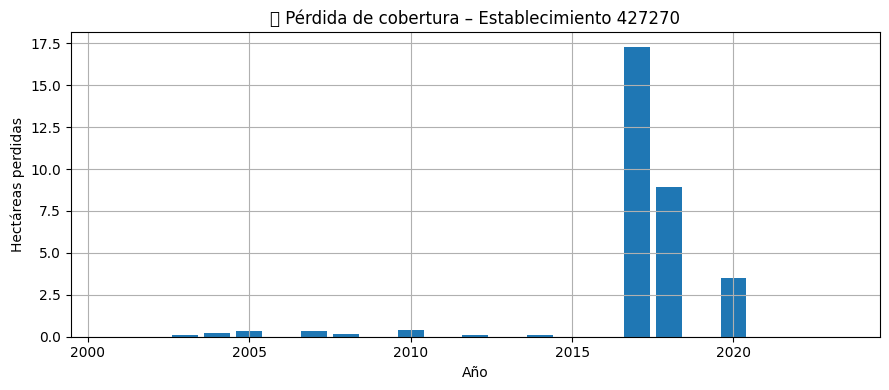

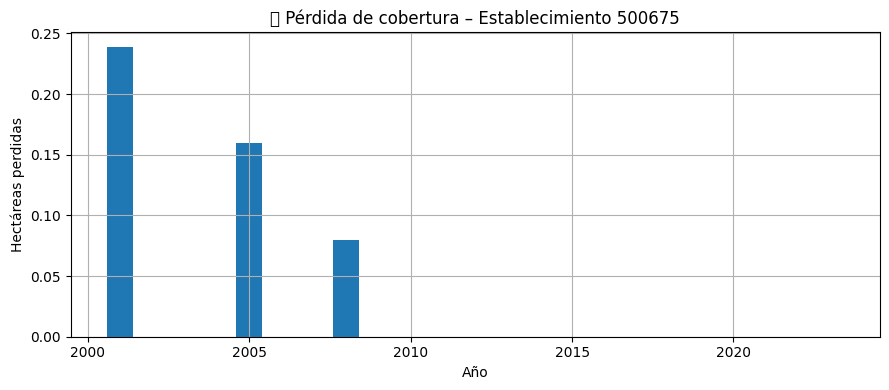

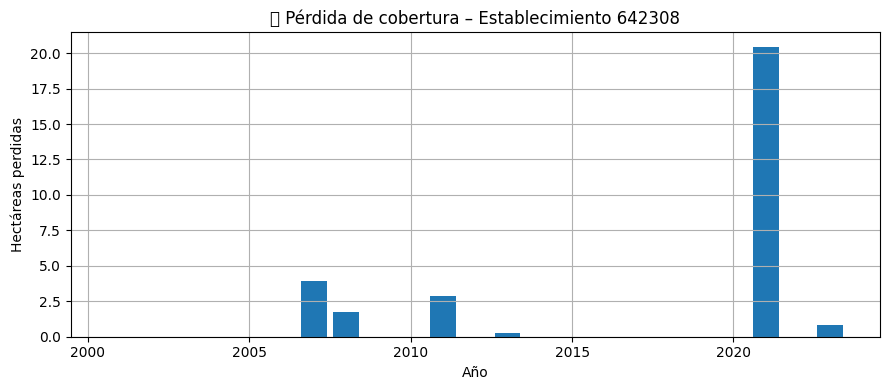

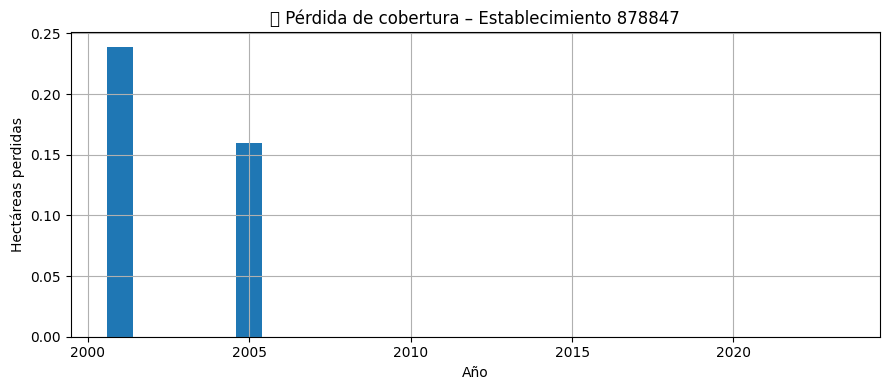

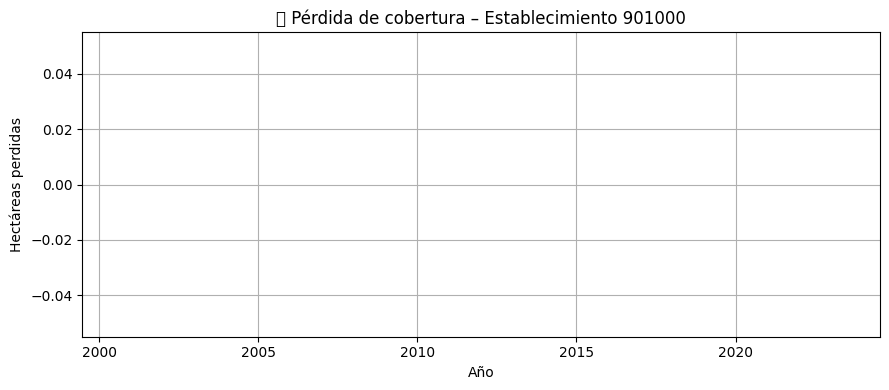

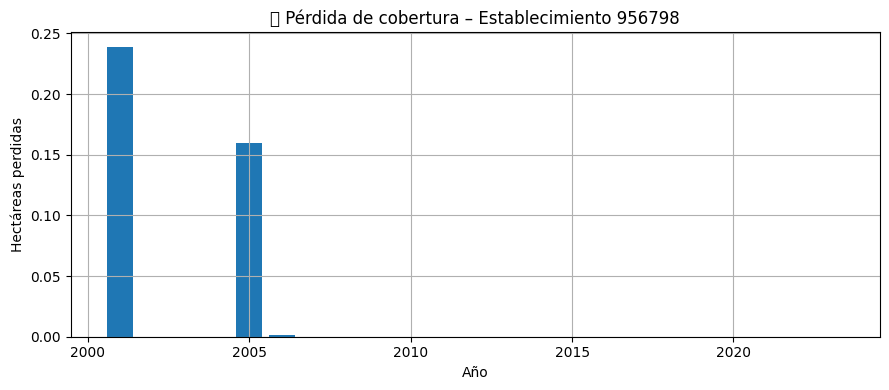

🗺️ Mapa guardado: D:\sentinel_data\map_loss_500675.html


🗺️ Mapa guardado: D:\sentinel_data\map_loss_956798.html


🗺️ Mapa guardado: D:\sentinel_data\map_loss_427270.html


🗺️ Mapa guardado: D:\sentinel_data\map_loss_901000.html


🗺️ Mapa guardado: D:\sentinel_data\map_loss_878847.html


🗺️ Mapa guardado: D:\sentinel_data\map_loss_642308.html


In [5]:
# -*- coding: utf-8 -*-
import os
import ee
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) Carpeta de trabajo + Inicializar EE
# =========================
BASE_DIR = r"D:\sentinel_data"
os.makedirs(BASE_DIR, exist_ok=True)
print("Carpeta de trabajo:", BASE_DIR)

# Inicialización con fallback a Authenticate()
try:
    ee.Initialize()
    print("EE inicializado (credenciales existentes).")
except Exception as e:
    print("EE no inicializado. Intentando autenticar…")
    ee.Authenticate()   # seguí el link, pegá el token
    ee.Initialize()
    print("EE autenticado e inicializado.")

# =========================
# 1) TUS POLÍGONOS (lat, lon)
# =========================
poligonos_latlon = {
    "500675": [
        (-27.31604,-61.15033), (-27.31222,-61.14733), (-27.31787,-61.13874), (-27.31421,-61.13583),
        (-27.31947,-61.12793), (-27.31238,-61.12184), (-27.31794,-61.11394), (-27.33952,-61.13256),
        (-27.33426,-61.14038), (-27.32686,-61.13437), (-27.31604,-61.15033)
    ],
    "956798": [
        (-27.34013,-61.14831), (-27.34745,-61.15441), (-27.35378,-61.14488), (-27.34692,-61.13904),
        (-27.35241,-61.13063), (-27.34509,-61.12454), (-27.34005,-61.13218), (-27.33258,-61.12591),
        (-27.32747,-61.13329), (-27.33434,-61.13965), (-27.33983,-61.13286), (-27.34615,-61.13930),
        (-27.34013,-61.14831)
    ],
    "427270": [
        (-25.08179,-62.56431), (-25.08226,-62.58817), (-25.10511,-62.58868), (-25.10519,-62.56336),
        (-25.08179,-62.56431)
    ],
    "901000": [
        (-27.33233,-61.12608), (-27.32753,-61.12200), (-27.32509,-61.11993), (-27.32288,-61.12335),
        (-27.32002,-61.12779), (-27.32669,-61.13389), (-27.33233,-61.12608)
    ],
    "878847": [
        (-27.33899,-61.13244), (-27.33197,-61.12643), (-27.32709,-61.13389), (-27.33411,-61.14033),
        (-27.33899,-61.13244)
    ],
    "642308": [
        (-27.06570,-61.36418), (-27.06356,-61.36753), (-27.05637,-61.36130), (-27.05882,-61.35821),
        (-27.06570,-61.36418)
    ],
}

# Helper: convertir (lat, lon) -> [lon, lat]
def to_lonlat(coords_latlon):
    return [[lon, lat] for (lat, lon) in coords_latlon]

# Construir geometrías EE
establecimientos = {
    est: ee.Geometry.Polygon([to_lonlat(coords)])
    for est, coords in poligonos_latlon.items()
}

# =========================
# 2) Colecciones/datasets
# =========================
# MapBiomas Argentina C1 (integración v1) - clase 3 = Bosque natural
mapbiomas = ee.Image("projects/mapbiomas-public/assets/argentina/collection1/mapbiomas_argentina_collection1_integration_v1")
anios_mapbiomas = list(range(2000, 2023))
clase_bosque = 3

# Hansen Global Forest Change v1.11 (2023)
hansen = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")
lossyear = hansen.select("lossyear")  # valores 1..23 => años 2001..2023

# =========================
# 3) Funciones de cálculo
# =========================
def bosque_ha_por_anio(geom, anios, clase=3, scale=30):
    """Devuelve lista de dicts con {'año', 'ha_bosque'} para el polígono dado."""
    out = []
    for anio in anios:
        banda = f"classification_{anio}"
        bosque = mapbiomas.select(banda).eq(clase)
        area_ha = bosque.multiply(ee.Image.pixelArea()).divide(10000)  # m² -> ha
        stats = area_ha.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geom,
            scale=scale,
            maxPixels=1e13
        ).getInfo()
        ha_val = stats.get(banda, 0) if stats else 0
        out.append({"año": anio, "ha_bosque": float(ha_val or 0)})
    return out

def perdida_ha_hansen_por_anio(geom, first=1, last=23, scale=30):
    """Devuelve lista de dicts con {'año', 'ha_perdida'} 2001..2023 para el polígono dado."""
    out = []
    for v in range(first, last + 1):
        # máscara año específico de pérdida
        mask = lossyear.eq(v)
        area_ha = mask.multiply(ee.Image.pixelArea()).divide(10000)
        stats = area_ha.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geom,
            scale=scale,
            maxPixels=1e13
        ).getInfo()
        ha_val = stats.get("lossyear", 0) if stats else 0
        out.append({"año": 2000 + v, "ha_perdida": float(ha_val or 0)})
    return out

# =========================
# 4) Ejecutar por establecimiento
# =========================
registros_bosque = []
registros_loss = []

for est_id, geom in establecimientos.items():
    # MapBiomas bosque natural
    datos_bosque = bosque_ha_por_anio(geom, anios_mapbiomas, clase=clase_bosque, scale=30)
    for row in datos_bosque:
        registros_bosque.append({"establecimiento": est_id, **row})

    # Hansen pérdida
    datos_loss = perdida_ha_hansen_por_anio(geom, first=1, last=23, scale=30)
    for row in datos_loss:
        registros_loss.append({"establecimiento": est_id, **row})

# DataFrames finales
df_bosque_all = pd.DataFrame(registros_bosque).sort_values(["establecimiento", "año"]).reset_index(drop=True)
df_loss_all   = pd.DataFrame(registros_loss).sort_values(["establecimiento", "año"]).reset_index(drop=True)

print("\n=== Bosque (MapBiomas clase 3) 2000–2022 ===")
print(df_bosque_all.head(12))

print("\n=== Pérdida de cobertura arbórea (Hansen) 2001–2023 ===")
print(df_loss_all.head(12))

# =========================
# 5) Exportar a CSV en D:\sentinel_data
# =========================
path_bosque = os.path.join(BASE_DIR, "bosque_mapbiomas_por_establecimiento.csv")
path_loss   = os.path.join(BASE_DIR, "perdida_hansen_por_establecimiento.csv")
df_bosque_all.to_csv(path_bosque, index=False, encoding="utf-8")
df_loss_all.to_csv(path_loss, index=False, encoding="utf-8")
print(f"✅ CSV guardado: {path_bosque}")
print(f"✅ CSV guardado: {path_loss}")

# =========================
# 6) (Opcional) Gráficos por polígono
# =========================
for est in df_bosque_all["establecimiento"].unique():
    d = df_bosque_all[df_bosque_all["establecimiento"] == est]
    plt.figure(figsize=(9,4))
    plt.plot(d["año"], d["ha_bosque"], marker="o")
    plt.title(f"🌳 Bosque natural (clase 3) – Establecimiento {est}")
    plt.xlabel("Año"); plt.ylabel("Hectáreas"); plt.grid(True); plt.tight_layout()
    # Guardar figura (opcional)
    # plt.savefig(os.path.join(BASE_DIR, f"bosque_{est}.png"), dpi=150)
    plt.show()

for est in df_loss_all["establecimiento"].unique():
    d = df_loss_all[df_loss_all["establecimiento"] == est]
    plt.figure(figsize=(9,4))
    plt.bar(d["año"], d["ha_perdida"])
    plt.title(f"🪵 Pérdida de cobertura – Establecimiento {est}")
    plt.xlabel("Año"); plt.ylabel("Hectáreas perdidas"); plt.grid(True); plt.tight_layout()
    # Guardar figura (opcional)
    # plt.savefig(os.path.join(BASE_DIR, f"perdida_{est}.png"), dpi=150)
    plt.show()
    
    
# =========================
# 7) Mapas Folium: pérdida (Hansen) en rojo por establecimiento
# =========================
import folium
from shapely.geometry import Polygon
import geopandas as gpd
from IPython.display import display

# Imagen Hansen y máscara binaria de pérdida (selfMask() deja transparentes los 0)
hansen = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")
loss_binary_global = hansen.select('loss').selfMask()  # 1 = hubo pérdida en algún año 2001-2023

def shapely_poly_from_latlon(coords_latlon):
    """Convierte [(lat,lon), ...] -> Shapely Polygon en (lon,lat)."""
    lonlat = [(lon, lat) for (lat, lon) in coords_latlon]
    return Polygon(lonlat)

for est_id, coords_latlon in poligonos_latlon.items():
    # EE geometry (lon,lat)
    aoi = ee.Geometry.Polygon([to_lonlat(coords_latlon)])
    # Shapely/GeoDataFrame para dibujar borde del polígono
    poly = shapely_poly_from_latlon(coords_latlon)

    # Clip de la pérdida al AOI y estilo rojo
    loss_clip = loss_binary_global.clip(aoi)
    loss_vis = {
        'min': 1,          # solo hay valores 1 (por selfMask)
        'max': 1,
        'palette': ['FF0000']
    }
    map_id = loss_clip.getMapId(loss_vis)

    # Centrar mapa en el centroide del polígono
    centroide = poly.centroid
    m = folium.Map(location=[centroide.y, centroide.x], zoom_start=14, control_scale=True)

    # Capa AOI (borde)
    gdf = gpd.GeoDataFrame({'establecimiento': [est_id], 'geometry': [poly]}, crs='EPSG:4326')
    folium.GeoJson(
        gdf,
        name=f"AOI {est_id}",
        style_function=lambda x: {"color": "#1f77b4", "weight": 2, "fill": False}
    ).add_to(m)

    # Capa de pérdida (rojo)
    folium.TileLayer(
        tiles=map_id['tile_fetcher'].url_format,
        attr='Hansen GFC v1.11',
        name='❌ Pérdida forestal 2001–2023',
        overlay=True,
        control=True,
        opacity=0.7
    ).add_to(m)

    # Controles
    folium.LayerControl(collapsed=False).add_to(m)

    # Mostrar (si estás en notebook)
    try:
        display(m)
    except:
        pass

    # Guardar HTML
    html_path = os.path.join(BASE_DIR, f"map_loss_{est_id}.html")
    m.save(html_path)
    print(f"🗺️ Mapa guardado: {html_path}")



In [11]:
# -*- coding: utf-8 -*-
import os
import ee
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from folium.plugins import MeasureControl, MousePosition, MiniMap

# =========================
# 0) Carpeta de trabajo + EE init
# =========================
BASE_DIR = r"D:\sentinel_data"
os.makedirs(BASE_DIR, exist_ok=True)
print("Carpeta de trabajo:", BASE_DIR)

try:
    ee.Initialize()
    print("EE inicializado.")
except Exception:
    print("Autenticando EE...")
    ee.Authenticate()
    ee.Initialize()
    print("EE autenticado e inicializado.")

# =========================
# 1) TUS POLÍGONOS (lat, lon)
# =========================
poligonos_latlon = {
    "500675": [
        (-27.31604,-61.15033), (-27.31222,-61.14733), (-27.31787,-61.13874), (-27.31421,-61.13583),
        (-27.31947,-61.12793), (-27.31238,-61.12184), (-27.31794,-61.11394), (-27.33952,-61.13256),
        (-27.33426,-61.14038), (-27.32686,-61.13437), (-27.31604,-61.15033)
    ],
    "956798": [
        (-27.34013,-61.14831), (-27.34745,-61.15441), (-27.35378,-61.14488), (-27.34692,-61.13904),
        (-27.35241,-61.13063), (-27.34509,-61.12454), (-27.34005,-61.13218), (-27.33258,-61.12591),
        (-27.32747,-61.13329), (-27.33434,-61.13965), (-27.33983,-61.13286), (-27.34615,-61.13930),
        (-27.34013,-61.14831)
    ],
    "427270": [
        (-25.08179,-62.56431), (-25.08226,-62.58817), (-25.10511,-62.58868), (-25.10519,-62.56336),
        (-25.08179,-62.56431)
    ],
    "901000": [
        (-27.33233,-61.12608), (-27.32753,-61.12200), (-27.32509,-61.11993), (-27.32288,-61.12335),
        (-27.32002,-61.12779), (-27.32669,-61.13389), (-27.33233,-61.12608)
    ],
    "878847": [
        (-27.33899,-61.13244), (-27.33197,-61.12643), (-27.32709,-61.13389), (-27.33411,-61.14033),
        (-27.33899,-61.13244)
    ],
    "642308": [
        (-27.06570,-61.36418), (-27.06356,-61.36753), (-27.05637,-61.36130), (-27.05882,-61.35821),
        (-27.06570,-61.36418)
    ],
}

def to_lonlat(coords_latlon):
    """Convierte [(lat,lon), ...] -> [[lon,lat], ...]"""
    return [[lon, lat] for (lat, lon) in coords_latlon]

# Geometrías EE y Shapely
ee_polys = []
shapely_polys = []
for _, coords in poligonos_latlon.items():
    lonlat = to_lonlat(coords)
    ee_polys.append(ee.Geometry.Polygon([lonlat]))
    shapely_polys.append(Polygon(lonlat))

union_shp = unary_union(shapely_polys)
bounds = union_shp.bounds  # (minx, miny, maxx, maxy)
centroid = union_shp.centroid
aoi_all = ee.FeatureCollection([ee.Feature(g) for g in ee_polys]).geometry()

# =========================
# 2) WDPA (ARG): intersección + nearest por establecimiento
# =========================
wdpa_arg = ee.FeatureCollection("WCMC/WDPA/current/polygons").filter(ee.Filter.eq('ISO3', 'ARG'))

def area_protegida_km2_en_geom(geom, scale=100):
    """Área protegida (km²) y nombres de WDPA intersectadas con 'geom'."""
    fc = wdpa_arg.filterBounds(geom)
    if fc.size().getInfo() == 0:
        return 0.0, []
    mask = fc.reduceToImage(properties=['WDPA_PID'], reducer=ee.Reducer.first()).gt(0)
    area_m2 = mask.multiply(ee.Image.pixelArea())
    stats = area_m2.reduceRegion(
        reducer=ee.Reducer.sum(), geometry=geom, scale=scale, maxPixels=1e13
    ).getInfo()
    m2 = stats.get('first', 0) if stats else 0
    km2 = (m2 or 0) / 1e6
    try:
        names = ee.List(fc.aggregate_array('NAME')).distinct().getInfo()
        names = sorted([n for n in names if n])
    except Exception:
        names = []
    return float(km2), names

def nearest_wdpa_info(geom):
    """Nombre y distancia (km) a WDPA más cercana. Si intersecta, distancia=0."""
    with_dist = wdpa_arg.map(lambda f: f.set('dist_m', f.geometry().distance(geom)))
    nearest = with_dist.sort('dist_m').first()
    name = nearest.get('NAME').getInfo()
    dist_m = nearest.get('dist_m').getInfo()
    return name, round((dist_m or 0) / 1000.0, 3)

rows = []
for est_id, coords in poligonos_latlon.items():
    geom = ee.Geometry.Polygon([to_lonlat(coords)])
    km2_prot, names = area_protegida_km2_en_geom(geom, scale=100)
    nearest_name, nearest_km = nearest_wdpa_info(geom)
    rows.append({
        "establecimiento": est_id,
        "interseca_wdpa": km2_prot > 0,
        "km2_protegidos_en_poligono": round(km2_prot, 4),
        "areas_protegidas_intersectadas": "; ".join(names),
        "wdpa_mas_cercana": nearest_name,
        "distancia_min_km": nearest_km
    })

df_wdpa = pd.DataFrame(rows).sort_values("establecimiento").reset_index(drop=True)
csv_path = os.path.join(BASE_DIR, "wdpa_intersecciones.csv")
df_wdpa.to_csv(csv_path, index=False, encoding="utf-8")
print("✅ CSV WDPA:", csv_path)
print(df_wdpa)

# =========================
# 3) Capas administrativas + WDPA (tiles EE)
# =========================
buffer_km = 200
buffer_m = buffer_km * 1000

gaul1 = (ee.FeatureCollection('FAO/GAUL/2015/level1')
         .filter(ee.Filter.eq('ADM0_NAME', 'Argentina'))
         .filterBounds(aoi_all.buffer(buffer_m)))
gaul2 = (ee.FeatureCollection('FAO/GAUL/2015/level2')
         .filter(ee.Filter.eq('ADM0_NAME', 'Argentina'))
         .filterBounds(aoi_all.buffer(buffer_m)))

# Provincias (borde azul), Departamentos (borde naranja)
prov_edge = ee.Image().byte().paint(gaul1, 1, 2).visualize(palette=['#1f78b4'], opacity=0.95)
dept_edge = ee.Image().byte().paint(gaul2, 1, 1).visualize(palette=['#ff7f00'], opacity=0.95)

# WDPA cerca de tus AOI
wdpa_near = wdpa_arg.filterBounds(aoi_all.buffer(buffer_m))
wdpa_fill = ee.Image().byte().paint(wdpa_near, 1).visualize(palette=['#006400'], opacity=0.35)
wdpa_bord = ee.Image().byte().paint(wdpa_near, 1, 2).visualize(palette=['#006400'], opacity=0.95)

wdpa_mapid = wdpa_fill.blend(wdpa_bord).getMapId()
prov_mapid = prov_edge.getMapId()
dept_mapid = dept_edge.getMapId()

# =========================
# 4) Mapa contextual con basemaps + labels + capas EE + polígonos
# =========================
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=7, control_scale=True, tiles=None)

# Basemaps
folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri World Imagery'
).add_to(m)
folium.TileLayer('CartoDB positron', name='Carto Positron (claro)').add_to(m)
# Alternativa a Stamen Terrain:
folium.TileLayer(
    tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    attr='© OpenTopoMap (CC-BY-SA), © OpenStreetMap contributors',
    name='OpenTopoMap'
).add_to(m)

# Labels de localidades (overlay)
folium.TileLayer(
    tiles='https://{s}.basemaps.cartocdn.com/light_only_labels/{z}/{x}/{y}.png',
    attr='© CartoDB',
    name='Etiquetas (localidades)',
    overlay=True,
    control=True,
    subdomains='abcd',
    opacity=1.0
).add_to(m)

# Capas EE
folium.TileLayer(
    tiles=wdpa_mapid['tile_fetcher'].url_format,
    attr='WDPA (WCMC/IUCN)',
    name='Áreas protegidas (WDPA)',
    overlay=True,
    control=True,
    opacity=1.0
).add_to(m)
folium.TileLayer(
    tiles=prov_mapid['tile_fetcher'].url_format,
    attr='GAUL nivel 1 (FAO)',
    name='Provincias',
    overlay=True,
    control=True,
    opacity=1.0
).add_to(m)
folium.TileLayer(
    tiles=dept_mapid['tile_fetcher'].url_format,
    attr='GAUL nivel 2 (FAO)',
    name='Departamentos',
    overlay=True,
    control=True,
    opacity=1.0
).add_to(m)

# Establecimientos (bordes rojos) + popups con métricas WDPA
gdf = gpd.GeoDataFrame({"establecimiento": list(poligonos_latlon.keys()),
                        "geometry": shapely_polys}, crs="EPSG:4326")
gdf = gdf.merge(df_wdpa[["establecimiento","interseca_wdpa","km2_protegidos_en_poligono",
                          "wdpa_mas_cercana","distancia_min_km"]],
                on="establecimiento", how="left")

def popup_html(row):
    return (f"<b>Establecimiento:</b> {row['establecimiento']}<br>"
            f"<b>Interseca WDPA:</b> {row['interseca_wdpa']}<br>"
            f"<b>Área WDPA dentro:</b> {row['km2_protegidos_en_poligono']} km²<br>"
            f"<b>WDPA más cercana:</b> {row['wdpa_mas_cercana']}<br>"
            f"<b>Distancia mínima:</b> {row['distancia_min_km']} km")

est_fg = folium.FeatureGroup(name="Establecimientos", show=True)
folium.GeoJson(
    gdf,
    style_function=lambda f: {"color": "#e41a1c", "weight": 3, "fill": False},
    tooltip=folium.GeoJsonTooltip(fields=["establecimiento"], aliases=["ID: "])
).add_to(est_fg)

# Marcadores en puntos representativos con popup
for _, r in gdf.iterrows():
    c = r.geometry.representative_point()
    folium.CircleMarker(
        location=[c.y, c.x], radius=4, color="#e41a1c", fill=True, fill_opacity=0.8,
        tooltip=f"Establecimiento {r['establecimiento']}",
        popup=folium.Popup(popup_html(r), max_width=350)
    ).add_to(est_fg)

est_fg.add_to(m)

# Herramientas
m.add_child(MeasureControl(position='topleft', primary_length_unit='kilometers', primary_area_unit='sqkilometers'))
MousePosition(position='bottomleft', separator=' | ', prefix="Lat/Lon", num_digits=5).add_to(m)
MiniMap(toggle_display=True, position='bottomright').add_to(m)

# Ajuste de vista y control de capas
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
folium.LayerControl(collapsed=False).add_to(m)

# Guardar
map_out = os.path.join(BASE_DIR, "map_contexto_todos.html")
m.save(map_out)
print("🗺️ Mapa contextual guardado:", map_out)


Carpeta de trabajo: D:\sentinel_data
EE inicializado.
✅ CSV WDPA: D:\sentinel_data\wdpa_intersecciones.csv
  establecimiento  interseca_wdpa  km2_protegidos_en_poligono  \
0          427270           False                         0.0   
1          500675           False                         0.0   
2          642308           False                         0.0   
3          878847           False                         0.0   
4          901000           False                         0.0   
5          956798           False                         0.0   

  areas_protegidas_intersectadas wdpa_mas_cercana  distancia_min_km  
0                                            Copo            68.889  
1                                           Chaco           147.333  
2                                            Copo           113.721  
3                                           Chaco           148.998  
4                                           Chaco           148.145  
5                

In [13]:
# =========================
# NUEVOS ESTABLECIMIENTOS + FIX WDPA (sin reduceToImage con campo string)
# =========================
import os, ee, folium, pandas as pd, geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from folium.plugins import MeasureControl, MousePosition, MiniMap

# ---- Base/EE por si corrés aislado
if 'BASE_DIR' not in globals():
    BASE_DIR = r"D:\sentinel_data"
    os.makedirs(BASE_DIR, exist_ok=True)

try:
    ee.Number(1).getInfo()
except Exception:
    try:
        ee.Initialize()
    except Exception:
        ee.Authenticate()
        ee.Initialize()

# ---- Helper y diccionario existente
if 'poligonos_latlon' not in globals():
    poligonos_latlon = {}

def to_lonlat(coords_latlon):
    return [[lon, lat] for (lat, lon) in coords_latlon]

# ---- 1) Agregar los dos nuevos (lat, lon)
poligonos_latlon.update({
    "290102": [
        (-29.87995,-63.32923), (-29.86402,-63.33163), (-29.85524,-63.33541), (-29.85538,-63.26726),
        (-29.85494,-63.25911), (-29.85643,-63.25636), (-29.85702,-63.24675), (-29.85643,-63.22786),
        (-29.88292,-63.22580), (-29.88292,-63.18666), (-29.89096,-63.18254), (-29.88471,-63.12727),
        (-29.90138,-63.13002), (-29.90167,-63.10255), (-29.93441,-63.10392), (-29.93560,-63.22898),
        (-29.93634,-63.32665), (-29.87995,-63.32923)
    ],
    "607244": [
        (-29.89384,-63.28480), (-29.91169,-63.19279), (-29.85275,-63.18935), (-29.85573,-63.28686),
        (-29.89384,-63.28480)
    ]
})

# ---- 2) Geometrías EE/Shapely para TODOS
ee_polys, shapely_polys = [], []
for _, coords in poligonos_latlon.items():
    lonlat = to_lonlat(coords)
    ee_polys.append(ee.Geometry.Polygon([lonlat]))
    shapely_polys.append(Polygon(lonlat))

union_shp = unary_union(shapely_polys)
bounds = union_shp.bounds
centroid = union_shp.centroid
aoi_all = ee.FeatureCollection([ee.Feature(g) for g in ee_polys]).geometry()

# ---- 3) WDPA ARG y funciones (FIX: usar geometría, NO reduceToImage con 'WDPA_PID')
wdpa_arg = ee.FeatureCollection("WCMC/WDPA/current/polygons").filter(ee.Filter.eq('ISO3', 'ARG'))

def area_protegida_km2_en_geom(geom):
    """Área protegida (km²) por intersección geométrica + nombres WDPA."""
    fc = wdpa_arg.filterBounds(geom)
    if fc.size().getInfo() == 0:
        return 0.0, []
    inter = fc.geometry().intersection(geom, 1)  # maxError=1 m aprox (geodésico)
    m2 = inter.area(1).getInfo() or 0.0
    km2 = m2 / 1e6
    try:
        names = (ee.List(fc.aggregate_array('NAME')).distinct().getInfo() or [])
        names = sorted([n for n in names if n])
    except Exception:
        names = []
    return float(km2), names

def nearest_wdpa_info(geom):
    """WDPA más cercana (nombre, distancia_km). Si intersecta, distancia≈0."""
    with_dist = wdpa_arg.map(lambda f: f.set('dist_m', f.geometry().distance(geom)))
    nearest = with_dist.sort('dist_m').first()
    name = nearest.get('NAME').getInfo()
    dist_m = nearest.get('dist_m').getInfo()
    return name, round((dist_m or 0) / 1000.0, 3)

# ---- 4) Calcular WDPA para los nuevos y actualizar CSV
new_ids = ["290102", "607244"]
rows_new = []
for est_id in new_ids:
    geom = ee.Geometry.Polygon([to_lonlat(poligonos_latlon[est_id])])
    km2_prot, names = area_protegida_km2_en_geom(geom)
    nearest_name, nearest_km = nearest_wdpa_info(geom)
    rows_new.append({
        "establecimiento": est_id,
        "interseca_wdpa": km2_prot > 0,
        "km2_protegidos_en_poligono": round(km2_prot, 4),
        "areas_protegidas_intersectadas": "; ".join(names),
        "wdpa_mas_cercana": nearest_name,
        "distancia_min_km": nearest_km
    })
df_new = pd.DataFrame(rows_new)

csv_path = os.path.join(BASE_DIR, "wdpa_intersecciones.csv")
if 'df_wdpa' in globals():
    df_wdpa = (pd.concat([df_wdpa, df_new], ignore_index=True)
               .drop_duplicates(subset=['establecimiento'], keep='last')
               .sort_values('establecimiento')
               .reset_index(drop=True))
else:
    # si no existía, calcular para todos
    rows_all = []
    for est_id, coords in poligonos_latlon.items():
        geom = ee.Geometry.Polygon([to_lonlat(coords)])
        km2_prot, names = area_protegida_km2_en_geom(geom)
        nearest_name, nearest_km = nearest_wdpa_info(geom)
        rows_all.append({
            "establecimiento": est_id,
            "interseca_wdpa": km2_prot > 0,
            "km2_protegidos_en_poligono": round(km2_prot, 4),
            "areas_protegidas_intersectadas": "; ".join(names),
            "wdpa_mas_cercana": nearest_name,
            "distancia_min_km": nearest_km
        })
    df_wdpa = pd.DataFrame(rows_all).sort_values('establecimiento').reset_index(drop=True)

df_wdpa.to_csv(csv_path, index=False, encoding="utf-8")
print("✅ CSV WDPA actualizado:", csv_path)
print(df_wdpa[df_wdpa['establecimiento'].isin(new_ids)])

# ---- 5) Regenerar MAPA con contexto (WDPA + provincias + departamentos + TODOS)
buffer_km = 200
buffer_m = buffer_km * 1000

gaul1 = (ee.FeatureCollection('FAO/GAUL/2015/level1')
         .filter(ee.Filter.eq('ADM0_NAME', 'Argentina'))
         .filterBounds(aoi_all.buffer(buffer_m)))
gaul2 = (ee.FeatureCollection('FAO/GAUL/2015/level2')
         .filter(ee.Filter.eq('ADM0_NAME', 'Argentina'))
         .filterBounds(aoi_all.buffer(buffer_m)))

prov_edge = ee.Image().byte().paint(gaul1, 1, 2).visualize(palette=['#1f78b4'], opacity=0.95)
dept_edge = ee.Image().byte().paint(gaul2, 1, 1).visualize(palette=['#ff7f00'], opacity=0.95)

wdpa_near = wdpa_arg.filterBounds(aoi_all.buffer(buffer_m))
wdpa_fill = ee.Image().byte().paint(wdpa_near, 1).visualize(palette=['#006400'], opacity=0.35)
wdpa_bord = ee.Image().byte().paint(wdpa_near, 1, 2).visualize(palette=['#006400'], opacity=0.95)

wdpa_mapid = wdpa_fill.blend(wdpa_bord).getMapId()
prov_mapid = prov_edge.getMapId()
dept_mapid = dept_edge.getMapId()

m = folium.Map(location=[centroid.y, centroid.x], zoom_start=7, control_scale=True, tiles=None)

# Basemaps
folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri World Imagery'
).add_to(m)
folium.TileLayer('CartoDB positron', name='Carto Positron (claro)').add_to(m)
folium.TileLayer(
    tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    attr='© OpenTopoMap (CC-BY-SA), © OpenStreetMap contributors',
    name='OpenTopoMap'
).add_to(m)
# Etiquetas de localidades
folium.TileLayer(
    tiles='https://{s}.basemaps.cartocdn.com/light_only_labels/{z}/{x}/{y}.png',
    attr='© CartoDB',
    name='Etiquetas (localidades)',
    overlay=True, control=True, subdomains='abcd', opacity=1.0
).add_to(m)

# Capas EE
folium.TileLayer(
    tiles=wdpa_mapid['tile_fetcher'].url_format, attr='WDPA (WCMC/IUCN)',
    name='Áreas protegidas (WDPA)', overlay=True, control=True, opacity=1.0
).add_to(m)
folium.TileLayer(
    tiles=prov_mapid['tile_fetcher'].url_format, attr='GAUL nivel 1 (FAO)',
    name='Provincias', overlay=True, control=True, opacity=1.0
).add_to(m)
folium.TileLayer(
    tiles=dept_mapid['tile_fetcher'].url_format, attr='GAUL nivel 2 (FAO)',
    name='Departamentos', overlay=True, control=True, opacity=1.0
).add_to(m)

# GeoJSON de TODOS + popups con métricas WDPA
gdf = gpd.GeoDataFrame({"establecimiento": list(poligonos_latlon.keys()),
                        "geometry": shapely_polys}, crs="EPSG:4326")
gdf = gdf.merge(df_wdpa[["establecimiento","interseca_wdpa","km2_protegidos_en_poligono",
                          "wdpa_mas_cercana","distancia_min_km"]],
                on="establecimiento", how="left")

def popup_html(row):
    return (f"<b>Establecimiento:</b> {row['establecimiento']}<br>"
            f"<b>Interseca WDPA:</b> {row['interseca_wdpa']}<br>"
            f"<b>Área WDPA dentro:</b> {row['km2_protegidos_en_poligono']} km²<br>"
            f"<b>WDPA más cercana:</b> {row['wdpa_mas_cercana']}<br>"
            f"<b>Distancia mínima:</b> {row['distancia_min_km']} km")

fg = folium.FeatureGroup(name="Establecimientos", show=True)
folium.GeoJson(
    gdf,
    style_function=lambda f: {"color": "#e41a1c", "weight": 3, "fill": False},
    tooltip=folium.GeoJsonTooltip(fields=["establecimiento"], aliases=["ID: "])
).add_to(fg)

for _, r in gdf.iterrows():
    c = r.geometry.representative_point()
    folium.CircleMarker(
        location=[c.y, c.x], radius=4, color="#e41a1c", fill=True, fill_opacity=0.8,
        tooltip=f"Establecimiento {r['establecimiento']}",
        popup=folium.Popup(popup_html(r), max_width=350)
    ).add_to(fg)

fg.add_to(m)

# Herramientas y vista
m.add_child(MeasureControl(position='topleft', primary_length_unit='kilometers', primary_area_unit='sqkilometers'))
MousePosition(position='bottomleft', separator=' | ', prefix="Lat/Lon", num_digits=5).add_to(m)
MiniMap(toggle_display=True, position='bottomright').add_to(m)
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
folium.LayerControl(collapsed=False).add_to(m)

map_out = os.path.join(BASE_DIR, "map_contexto_todos.html")
m.save(map_out)
print("🗺️ Mapa contextual guardado:", map_out)


✅ CSV WDPA actualizado: D:\sentinel_data\wdpa_intersecciones.csv
  establecimiento  interseca_wdpa  km2_protegidos_en_poligono  \
0          290102            True                    148.0718   
3          607244            True                     49.3520   

                   areas_protegidas_intersectadas  \
0  Bañados del Río Dulce y Laguna de Mar Chiquita   
3  Bañados del Río Dulce y Laguna de Mar Chiquita   

                                 wdpa_mas_cercana  distancia_min_km  
0  Bañados del Río Dulce y Laguna de Mar Chiquita               0.0  
3  Bañados del Río Dulce y Laguna de Mar Chiquita               0.0  
🗺️ Mapa contextual guardado: D:\sentinel_data\map_contexto_todos.html


In [1]:
# -*- coding: utf-8 -*-
import os
import ee
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from folium.plugins import MeasureControl, MousePosition, MiniMap

# =========================
# 0) Carpeta de trabajo + EE init (GRUPO NUEVO)
# =========================
BASE_DIR = r"D:\sentinel_data"
GROUP_TAG = "lote_02"  # <- nombre del nuevo grupo
OUT_DIR = os.path.join(BASE_DIR, GROUP_TAG)
os.makedirs(OUT_DIR, exist_ok=True)
print("Carpeta de salida:", OUT_DIR)

try:
    ee.Initialize()
    print("EE inicializado.")
except Exception:
    print("Autenticando EE...")
    ee.Authenticate()
    ee.Initialize()
    print("EE autenticado e inicializado.")

# =========================
# 1) Polígonos NUEVOS (lat, lon) - NO se mezclan con los anteriores
# =========================
poligonos_latlon_lote02 = {
    "828023": [(-26.55439,-62.01367), (-26.55421,-62.05002), (-26.54285,-62.05002),
               (-26.54285,-62.04659), (-26.53863,-62.04668), (-26.53840,-62.01372),
               (-26.55439,-62.01367)],
    "846358": [(-26.56189,-62.06719), (-26.56220,-62.05457), (-26.53352,-62.05482),
               (-26.53364,-62.06745), (-26.56189,-62.06719)],
    "629461": [(-26.61339260150327, -62.041168212890625), (-26.61369954864527, -62.013702392578125),
               (-26.645003827815252, -62.013702392578125), (-26.645003827815252, -62.04082489013672),
               (-26.61339260150327, -62.041168212890625)],
    "827998": [(-26.69923,-61.98963), (-26.69961,-61.96422), (-26.70644,-61.96431),
               (-26.70659,-61.94877), (-26.70943,-61.94894), (-26.70927,-61.96414),
               (-26.72606,-61.96431), (-26.72637,-61.98946), (-26.69923,-61.98963)],
    "857625": [(-26.71606,-61.96423), (-26.72277,-61.96423), (-26.72275,-61.94912),
               (-26.71604,-61.94914), (-26.71606,-61.96423)],
    "885496": [(-26.70657,-61.94905), (-26.70320,-61.94901), (-26.70314,-61.94351),
               (-26.69938,-61.94350), (-26.69938,-61.93826), (-26.70866,-61.93857),
               (-26.70920,-61.93852), (-26.70960,-61.93856), (-26.71127,-61.93858),
               (-26.71115,-61.94841), (-26.70659,-61.94831), (-26.70657,-61.94905)],
    "885498": [(-26.69938,-61.93364), (-26.72599,-61.93347), (-26.72599,-61.93913),
               (-26.69954,-61.93930), (-26.69938,-61.93364)],
    "457784": [(-26.596662736348552, -62.26827621459961), (-26.596662736348552, -62.28921890258789),
               (-26.620835837409633, -62.28896141052246), (-26.62045217730121, -62.26831912994385),
               (-26.596662736348552, -62.26827621459961)],
    "457782": [(-26.572254234660342, -62.28973388671875), (-26.572254234660342, -62.26819038391113),
               (-26.59635574348833, -62.26801872253418), (-26.596509240021383, -62.2895622253418),
               (-26.572254234660342, -62.28973388671875)],
    "657906": [(-26.58622,-62.04183), (-26.57632,-62.06646), (-26.56220,-62.06741),
               (-26.56227,-62.05470), (-26.53402,-62.05470), (-26.53402,-62.04655),
               (-26.54224,-62.04724), (-26.54224,-62.05007), (-26.55383,-62.05007),
               (-26.55444,-62.04243), (-26.58622,-62.04183)],
    "923028": [(-26.21967,-62.60320), (-26.19397,-62.61197), (-26.17601,-62.61359),
               (-26.17558,-62.57560), (-26.17177,-62.57575), (-26.17146,-62.55208),
               (-26.17592,-62.55197), (-26.19449,-62.55213), (-26.19453,-62.57547),
               (-26.19449,-62.57970), (-26.19950,-62.57899), (-26.21967,-62.60320)],
    "937514": [(-26.61523,-61.96402), (-26.61063,-61.97681), (-26.58791,-61.97664),
               (-26.58830,-61.96394), (-26.61523,-61.96402)],
    "958542": [(-26.63265,-61.97723), (-26.63253,-61.96394), (-26.67212,-61.96405),
               (-26.67199,-61.98412), (-26.64546,-61.98409), (-26.64531,-61.97688),
               (-26.63265,-61.97723)],
    "629421": [(-26.63273,-61.97834), (-26.63273,-61.92684), (-26.55536,-61.92650),
               (-26.55414,-61.97662), (-26.63273,-61.97834)],
    "629442": [(-26.419544943230655, -61.812171936035156), (-26.420467337951784, -61.71192169189453),
               (-26.446598788443428, -61.71192169189453), (-26.446598788443428, -61.81234359741211),
               (-26.419544943230655, -61.812171936035156)],
    "457780": [(-26.53678,-61.81210), (-26.50990,-61.81220), (-26.50944,-61.71213),
               (-26.53663,-61.71195), (-26.53678,-61.81210)],
    "926627": [(-26.13517,-61.96068), (-26.15297,-61.96102), (-26.15343,-61.90961),
               (-26.13556,-61.90961), (-26.13517,-61.96068)],
    "675950": [(-26.72686,-62.14442), (-26.75403,-62.14414), (-26.75389,-62.11494),
               (-26.72687,-62.11545), (-26.72686,-62.14442)],
    "875133": [(-26.75366,-62.09800), (-26.78091,-62.09765), (-26.78076,-62.08830),
               (-26.75366,-62.08865), (-26.75366,-62.09800)],
    "890091": [(-26.75394,-62.08805), (-26.77134,-62.08784), (-26.77116,-62.06466),
               (-26.75384,-62.06493), (-26.75394,-62.08805)],
    "952720": [(-26.73982,-62.16416), (-26.75412,-62.16403), (-26.75393,-62.14434),
               (-26.73956,-62.14455), (-26.73982,-62.16416)],
    "918970": [(-26.72683,-62.12247), (-26.72675,-62.11526), (-26.75373,-62.11517),
               (-26.75373,-62.12247), (-26.72683,-62.12247)],
}

def to_lonlat(coords_latlon):
    return [[lon, lat] for (lat, lon) in coords_latlon]

# Geometrías EE y Shapely para ESTE grupo
ee_polys_02, shapely_polys_02 = [], []
for _, coords in poligonos_latlon_lote02.items():
    lonlat = to_lonlat(coords)
    ee_polys_02.append(ee.Geometry.Polygon([lonlat]))
    shapely_polys_02.append(Polygon(lonlat))

union_shp_02 = unary_union(shapely_polys_02)
bounds_02 = union_shp_02.bounds
centroid_02 = union_shp_02.centroid
aoi_all_02 = ee.FeatureCollection([ee.Feature(g) for g in ee_polys_02]).geometry()

# =========================
# 2) Deforestación (Hansen) y (opcional) Bosque MapBiomas
# =========================
hansen = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")
lossyear = hansen.select("lossyear")  # 1..23 => 2001..2023
mapbiomas = ee.Image("projects/mapbiomas-public/assets/argentina/collection1/mapbiomas_argentina_collection1_integration_v1")
anios_mapbiomas = list(range(2000, 2023))
CLASE_BOSQUE = 3

def perdida_ha_hansen_por_anio(geom, first=1, last=23, scale=30):
    rows = []
    for v in range(first, last + 1):
        mask = lossyear.eq(v)
        area_ha = mask.multiply(ee.Image.pixelArea()).divide(10000)
        stats = area_ha.reduceRegion(
            reducer=ee.Reducer.sum(), geometry=geom, scale=scale, maxPixels=1e13
        ).getInfo()
        ha_val = stats.get("lossyear", 0) if stats else 0
        rows.append({"año": 2000 + v, "ha_perdida": float(ha_val or 0)})
    return rows

def bosque_ha_mapbiomas_por_anio(geom, anios, clase=CLASE_BOSQUE, scale=30):
    rows = []
    for anio in anios:
        banda = f"classification_{anio}"
        bosque = mapbiomas.select(banda).eq(clase)
        area_ha = bosque.multiply(ee.Image.pixelArea()).divide(10000)
        stats = area_ha.reduceRegion(
            reducer=ee.Reducer.sum(), geometry=geom, scale=scale, maxPixels=1e13
        ).getInfo()
        ha_val = stats.get(banda, 0) if stats else 0
        rows.append({"año": anio, "ha_bosque": float(ha_val or 0)})
    return rows

# Ejecutar por establecimiento (solo ESTE grupo)
loss_records, bosque_records = [], []
for est_id, coords in poligonos_latlon_lote02.items():
    geom = ee.Geometry.Polygon([to_lonlat(coords)])
    # Hansen
    for r in perdida_ha_hansen_por_anio(geom, first=1, last=23, scale=30):
        loss_records.append({"establecimiento": est_id, **r})
    # MapBiomas (opcional, lo incluimos)
    for r in bosque_ha_mapbiomas_por_anio(geom, anios_mapbiomas, clase=CLASE_BOSQUE, scale=30):
        bosque_records.append({"establecimiento": est_id, **r})

df_loss_02 = pd.DataFrame(loss_records).sort_values(["establecimiento","año"]).reset_index(drop=True)
df_bosque_02 = pd.DataFrame(bosque_records).sort_values(["establecimiento","año"]).reset_index(drop=True)

# Guardar CSV
loss_csv = os.path.join(OUT_DIR, f"{GROUP_TAG}_hansen_loss_por_establecimiento.csv")
bosque_csv = os.path.join(OUT_DIR, f"{GROUP_TAG}_bosque_mapbiomas_por_establecimiento.csv")
df_loss_02.to_csv(loss_csv, index=False, encoding="utf-8")
df_bosque_02.to_csv(bosque_csv, index=False, encoding="utf-8")
print("✅ CSV Hansen:", loss_csv)
print("✅ CSV MapBiomas:", bosque_csv)

# Resumen de pérdida total 2001–2023 para popup
df_loss_tot_02 = (df_loss_02.groupby("establecimiento", as_index=False)
                  .agg(ha_perdida_total=("ha_perdida","sum")))

# =========================
# 3) Áreas protegidas (WDPA): intersección + nearest (FIX geométrico)
# =========================
wdpa_arg = ee.FeatureCollection("WCMC/WDPA/current/polygons").filter(ee.Filter.eq('ISO3', 'ARG'))

def area_protegida_km2_en_geom(geom):
    fc = wdpa_arg.filterBounds(geom)
    if fc.size().getInfo() == 0:
        return 0.0, []
    inter = fc.geometry().intersection(geom, 1)  # geodésico, maxError ~1 m
    m2 = inter.area(1).getInfo() or 0.0
    km2 = m2 / 1e6
    try:
        names = (ee.List(fc.aggregate_array('NAME')).distinct().getInfo() or [])
        names = sorted([n for n in names if n])
    except Exception:
        names = []
    return float(km2), names

def nearest_wdpa_info(geom):
    with_dist = wdpa_arg.map(lambda f: f.set('dist_m', f.geometry().distance(geom)))
    nearest = with_dist.sort('dist_m').first()
    name = nearest.get('NAME').getInfo()
    dist_m = nearest.get('dist_m').getInfo()
    return name, round((dist_m or 0) / 1000.0, 3)

rows_wdpa = []
for est_id, coords in poligonos_latlon_lote02.items():
    geom = ee.Geometry.Polygon([to_lonlat(coords)])
    km2_prot, names = area_protegida_km2_en_geom(geom)
    near_name, near_km = nearest_wdpa_info(geom)
    rows_wdpa.append({
        "establecimiento": est_id,
        "interseca_wdpa": km2_prot > 0,
        "km2_protegidos_en_poligono": round(km2_prot, 4),
        "areas_protegidas_intersectadas": "; ".join(names),
        "wdpa_mas_cercana": near_name,
        "distancia_min_km": near_km
    })

df_wdpa_02 = pd.DataFrame(rows_wdpa).sort_values("establecimiento").reset_index(drop=True)
wdpa_csv = os.path.join(OUT_DIR, f"{GROUP_TAG}_wdpa_intersecciones.csv")
df_wdpa_02.to_csv(wdpa_csv, index=False, encoding="utf-8")
print("✅ CSV WDPA:", wdpa_csv)
print(df_wdpa_02.head())

# =========================
# 4) Mapa único del grupo: WDPA + Provincias + Departamentos + Hansen loss + polígonos
# =========================
buffer_km = 200
buffer_m = buffer_km * 1000

gaul1 = (ee.FeatureCollection('FAO/GAUL/2015/level1')
         .filter(ee.Filter.eq('ADM0_NAME', 'Argentina'))
         .filterBounds(aoi_all_02.buffer(buffer_m)))
gaul2 = (ee.FeatureCollection('FAO/GAUL/2015/level2')
         .filter(ee.Filter.eq('ADM0_NAME', 'Argentina'))
         .filterBounds(aoi_all_02.buffer(buffer_m)))

# TILES EE: WDPA (verde), Provincias (azul), Depto (naranja)
prov_edge = ee.Image().byte().paint(gaul1, 1, 2).visualize(palette=['#1f78b4'], opacity=0.95)
dept_edge = ee.Image().byte().paint(gaul2, 1, 1).visualize(palette=['#ff7f00'], opacity=0.95)
wdpa_near = wdpa_arg.filterBounds(aoi_all_02.buffer(buffer_m))
wdpa_fill = ee.Image().byte().paint(wdpa_near, 1).visualize(palette=['#006400'], opacity=0.35)
wdpa_bord = ee.Image().byte().paint(wdpa_near, 1, 2).visualize(palette=['#006400'], opacity=0.95)
wdpa_mapid = wdpa_fill.blend(wdpa_bord).getMapId()
prov_mapid = prov_edge.getMapId()
dept_mapid = dept_edge.getMapId()

# Hansen loss binario 2001–2023 (rojo) recortado al buffer del grupo
loss_binary = hansen.select('loss').selfMask().clip(aoi_all_02.buffer(buffer_m))
loss_vis = {'min':1, 'max':1, 'palette':['#FF0000']}
loss_mapid = loss_binary.visualize(**loss_vis).getMapId()

# Mapa base
m02 = folium.Map(location=[centroid_02.y, centroid_02.x], zoom_start=7, control_scale=True, tiles=None)
# Basemaps
folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m02)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri', name='Esri World Imagery'
).add_to(m02)
folium.TileLayer('CartoDB positron', name='Carto Positron (claro)').add_to(m02)
folium.TileLayer(
    tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    attr='© OpenTopoMap (CC-BY-SA), © OpenStreetMap contributors', name='OpenTopoMap'
).add_to(m02)
# Labels de localidades
folium.TileLayer(
    tiles='https://{s}.basemaps.cartocdn.com/light_only_labels/{z}/{x}/{y}.png',
    attr='© CartoDB', name='Etiquetas (localidades)', overlay=True, control=True,
    subdomains='abcd', opacity=1.0
).add_to(m02)

# Capas EE de contexto
folium.TileLayer(tiles=wdpa_mapid['tile_fetcher'].url_format, attr='WDPA (WCMC/IUCN)',
                 name='Áreas protegidas (WDPA)', overlay=True, control=True, opacity=1.0).add_to(m02)
folium.TileLayer(tiles=prov_mapid['tile_fetcher'].url_format, attr='GAUL nivel 1 (FAO)',
                 name='Provincias', overlay=True, control=True, opacity=1.0).add_to(m02)
folium.TileLayer(tiles=dept_mapid['tile_fetcher'].url_format, attr='GAUL nivel 2 (FAO)',
                 name='Departamentos', overlay=True, control=True, opacity=1.0).add_to(m02)

# Capa Hansen (pérdida) en rojo
folium.TileLayer(tiles=loss_mapid['tile_fetcher'].url_format, attr='Hansen GFC v1.11',
                 name='Pérdida forestal 2001–2023 (Hansen)', overlay=True, control=True, opacity=0.7).add_to(m02)

# GeoJSON de los polígonos del grupo + POPUPS
gdf02 = gpd.GeoDataFrame({"establecimiento": list(poligonos_latlon_lote02.keys()),
                          "geometry": shapely_polys_02}, crs="EPSG:4326")
# Agrego WDPA y pérdida total para popup
gdf02 = gdf02.merge(df_wdpa_02[["establecimiento","interseca_wdpa","km2_protegidos_en_poligono",
                                "wdpa_mas_cercana","distancia_min_km"]],
                    on="establecimiento", how="left")
gdf02 = gdf02.merge(df_loss_tot_02, on="establecimiento", how="left")

def popup_html_02(row):
    return (f"<b>Establecimiento:</b> {row['establecimiento']}<br>"
            f"<b>Interseca WDPA:</b> {row['interseca_wdpa']}<br>"
            f"<b>Área WDPA dentro:</b> {row['km2_protegidos_en_poligono']} km²<br>"
            f"<b>WDPA más cercana:</b> {row['wdpa_mas_cercana']}<br>"
            f"<b>Distancia mínima:</b> {row['distancia_min_km']} km<br>"
            f"<b>Pérdida 2001–2023 (Hansen):</b> {round(row['ha_perdida_total'] or 0, 2)} ha")

fg02 = folium.FeatureGroup(name="Establecimientos (lote_02)", show=True)
folium.GeoJson(
    gdf02,
    name="AOI lote_02",
    style_function=lambda f: {"color": "#e41a1c", "weight": 3, "fill": False},
    tooltip=folium.GeoJsonTooltip(fields=["establecimiento"], aliases=["ID: "])
).add_to(fg02)

# Marcadores con popup (punto representativo interno)
for _, r in gdf02.iterrows():
    c = r.geometry.representative_point()
    folium.CircleMarker(
        location=[c.y, c.x], radius=4, color="#e41a1c", fill=True, fill_opacity=0.85,
        tooltip=f"Establecimiento {r['establecimiento']}",
        popup=folium.Popup(popup_html_02(r), max_width=360)
    ).add_to(fg02)

fg02.add_to(m02)

# Herramientas y vista
m02.add_child(MeasureControl(position='topleft', primary_length_unit='kilometers', primary_area_unit='sqkilometers'))
MousePosition(position='bottomleft', separator=' | ', prefix="Lat/Lon", num_digits=5).add_to(m02)
MiniMap(toggle_display=True, position='bottomright').add_to(m02)
m02.fit_bounds([[bounds_02[1], bounds_02[0]], [bounds_02[3], bounds_02[2]]])
folium.LayerControl(collapsed=False).add_to(m02)

# Guardar mapa
map_out_02 = os.path.join(OUT_DIR, f"{GROUP_TAG}_map_contexto.html")
m02.save(map_out_02)
print("🗺️ Mapa guardado:", map_out_02)


Carpeta de salida: D:\sentinel_data\lote_02
EE inicializado.


c:\Users\Win10\AppData\Local\Programs\Python\Python39\lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for UMD/hansen/global_forest_change_2023_v1_11! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2023_v1_11

  warnings.warn(warning, category=DeprecationWarning)


✅ CSV Hansen: D:\sentinel_data\lote_02\lote_02_hansen_loss_por_establecimiento.csv
✅ CSV MapBiomas: D:\sentinel_data\lote_02\lote_02_bosque_mapbiomas_por_establecimiento.csv
✅ CSV WDPA: D:\sentinel_data\lote_02\lote_02_wdpa_intersecciones.csv
  establecimiento  interseca_wdpa  km2_protegidos_en_poligono  \
0          457780           False                         0.0   
1          457782           False                         0.0   
2          457784           False                         0.0   
3          629421           False                         0.0   
4          629442           False                         0.0   

  areas_protegidas_intersectadas wdpa_mas_cercana  distancia_min_km  
0                                            Copo            39.410  
1                                            Copo            53.251  
2                                            Copo            55.707  
3                                            Copo            41.951  
4               